# Experiment fitting downward trend in data

Use shift in patient flows roughly from the start to end of March

In [4]:
%config IPCompleter.greedy=True

In [1]:
# https://www.cs.toronto.edu/~duvenaud/cookbook/
# https://docs.gpytorch.ai/en/latest/index.html
# https://distill.pub/2019/visual-exploration-gaussian-processes/

# Modules needed
import numpy as np
import pandas as pd
import os, time
from scipy.stats import norm
from plotnine import *
import plotnine
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

from funs_support import cvec

# Get the performance on the training/validation set
def gauss_pdf(x, mu, sig):
    pdf = (1 / sig * np.sqrt(2*np.pi)) * np.exp(-0.5 * ((x - mu) / sig)**2)
    return np.mean(pdf)

# sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF, Sum, Product, RationalQuadratic, DotProduct
# gpytorch
import torch
import gpytorch

from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import CosineKernel, LinearKernel, PeriodicKernel, RBFKernel, SpectralMixtureKernel
from gpytorch.kernels import ProductKernel, AdditiveKernel, ScaleKernel

def t2n(x):
    return x.detach().numpy()

dir_base = os.getcwd()
dir_flow = os.path.join(dir_base,'..','output','flow')

crit = norm.ppf(1-0.05/2)
seed = 1234

In [46]:
# np.random.seed(seed)
# x = cvec(np.linspace(10,20))
# y = x + np.random.randn(x.shape[0],1)
# kern = DotProduct(1) + WhiteKernel(1)
# print(kern)
# gpr = GaussianProcessRegressor(kernel=kern, random_state=0, n_restarts_optimizer=0, normalize_y=True).fit(x,y)
# print(gpr.kernel_)
# fig = sns.scatterplot(x=x.flat,y=gpr.predict(x,True)[0].flat,color='red')
# fig.scatter(x, y)

## (1) Test GPs on simulated data

R-squared for df1: 0.905, df2: 0.954


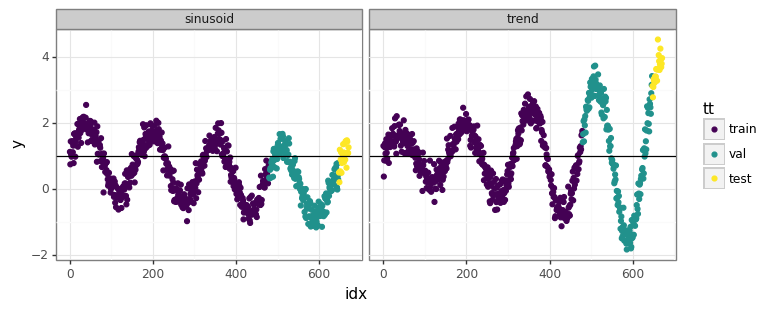

<ggplot: (8774122561245)>

In [185]:
ntrain, nval, ntest = 480, 168, 24
n = ntrain + nval + ntest
np.random.seed(seed)
# Data type 1: noisy downward sinusoid
idx1 = np.arange(n)
signal1, noise1, trend1 = np.sin(idx1/25)+1, 0.25*np.random.randn(n), np.linspace(0,-1,n)
df1 = pd.DataFrame({'idx':idx1, 'y':signal1+noise1+trend1,
                    'tt':pd.cut(idx1,bins=[0,ntrain,n-ntest,n+1],right=False,labels=['train','val','test'])})
# Data type 2: Multiplicative seansonal trend
noise2, signal2 = 0.25*np.random.randn(n), (signal1-1)*(-trend1+0.7)**2 + 1
df2 = pd.DataFrame({'idx':idx1, 'y':signal2+noise2, 'tt':df1.tt})
df = pd.concat([df1.assign(df='sinusoid'), df2.assign(df='trend')])
print('R-squared for df1: %0.3f, df2: %0.3f' % (r2_score(signal1+trend1, df1.y), r2_score(signal2, df2.y)))

enc1, enc2 = StandardScaler(), StandardScaler()
X1_train, y1_train = enc1.fit_transform(cvec(df1[df1.tt=='train'].idx)), df1[df1.tt=='train'].y.values
X2_train, y2_train = enc2.fit_transform(cvec(df2[df2.tt=='train'].idx)), df2[df2.tt=='train'].y.values
X1_val, y1_val = enc1.transform(cvec(df1[df1.tt=='val'].idx)), df1[df1.tt=='val'].y.values
X2_val, y2_val = enc2.transform(cvec(df2[df2.tt=='val'].idx)), df2[df2.tt=='val'].y.values
X1_test, y1_test = enc1.transform(cvec(df1[df1.tt=='test'].idx)), df1[df1.tt=='test'].y.values
X2_test, y2_test = enc2.transform(cvec(df2[df2.tt=='test'].idx)), df2[df2.tt=='test'].y.values
y1, y2 = df1.y.values, df2.y.values

plotnine.options.figure_size = (8, 3)
gg_df = (ggplot(df, aes(x='idx',y='y',color='tt')) + geom_point() + theme_bw() + 
         facet_wrap('~df') + geom_hline(yintercept=1))
gg_df

In [ ]:
X1_test.shape

## (1.A) sklearn

Different configurations of the hyperparameters will "fit" the training data, the goal is to tweak it on the validation set.

In [114]:
np.random.seed(seed)
nparams = 500
ll_seq = np.linspace(0.01,10, nparams)
ll_period = np.linspace(0.01, 6, nparams)
params = pd.DataFrame({'noise1':np.linspace(0, y1_train.var(), nparams),
                       'rbf_sig2':ll_seq, 'rbf_l':ll_seq,
                       'esq_l':ll_seq, 'esq_period':ll_seq,
                       'rq_l':ll_seq, 'rq_alpha':ll_seq})

nsamp = 100
sampled = params.apply(lambda x: x.sample(nsamp).values, axis=0)
# oracle1 = pd.Series({'noise1':0.0848,'rbf_sig2':0.733,'rbf_l':3.98,'esq_l':0.889,'esq_period':2.27})
# sampled = sampled.append(oracle1,ignore_index=True)
store_pred, store_perf, store_kern = [], [], []
for ii, rr in sampled.iterrows():
#     if (ii + 1) % 10 == 0:
#         print(ii + 1)
    kern_ii = ExpSineSquared(rr.esq_l, rr.esq_period) + \
              DotProduct(rr.noise1) + WhiteKernel(rr.noise1) #rr.rbf_sig2**2*RBF(rr.rbf_l) + 
    gpr_ii = GaussianProcessRegressor(kernel=kern_ii, normalize_y=True).fit(X1_train, y1_train)  #, optimizer=None
    mu_ii, se_ii = gpr_ii.predict(np.r_[X1_train, X1_val, X1_test], True)
    ll_train = r2_score(y1_train, mu_ii[:ntrain])  #gauss_pdf(y1_train, mu_ii[:ntrain], se_ii[:ntrain])
    ll_val = r2_score(y1_val, mu_ii[ntrain:n-ntest])  #gauss_pdf(y1_val, mu_ii[ntrain:n-ntest], se_ii[ntrain:n-ntest])
    ll_test = r2_score(y1_test, mu_ii[n-ntest:])  #gauss_pdf(y1_test, mu_ii[n-ntest:], se_ii[n-ntest:])
    tmp_ii = pd.DataFrame({'mu':mu_ii,'se':se_ii,'ii':ii})
    tmp_ll = pd.DataFrame({'ll':[ll_train, ll_val, ll_test], 'tt':['train','val','test'], 'ii':ii})
    store_pred.append(tmp_ii); store_kern.append(kern_ii); store_perf.append(tmp_ll)
dat_sampled = pd.concat(store_pred).reset_index().rename(columns={'index':'idx'})
dat_perf = pd.concat(store_perf).pivot('ii','tt','ll').reset_index().sort_values('val',ascending=False).reset_index(None,True)
print('Train > val: %0.3f, val > test: %0.3f' % (np.mean(dat_perf.train > dat_perf.val), np.mean(dat_perf.val > dat_perf.test)))
# Bick the best five training instances
ii_train = dat_perf.sort_values('train',ascending=False).head(5).ii.values
ii_val = dat_perf.sort_values('val',ascending=False).head(5).ii.values
ii_test = dat_perf.sort_values('test',ascending=False).head(5).ii.values
best_train = dat_sampled[dat_sampled.ii.isin(ii_train)].assign(tt='1Train').reset_index(None,True)
best_val = dat_sampled[dat_sampled.ii.isin(ii_val)].assign(tt='2Val').reset_index(None,True)
best_test = dat_sampled[dat_sampled.ii.isin(ii_test)].assign(tt='3Test').reset_index(None,True)
best_ii = pd.concat([best_train, best_val, best_test])

Train > val: 1.000, val > test: 1.000


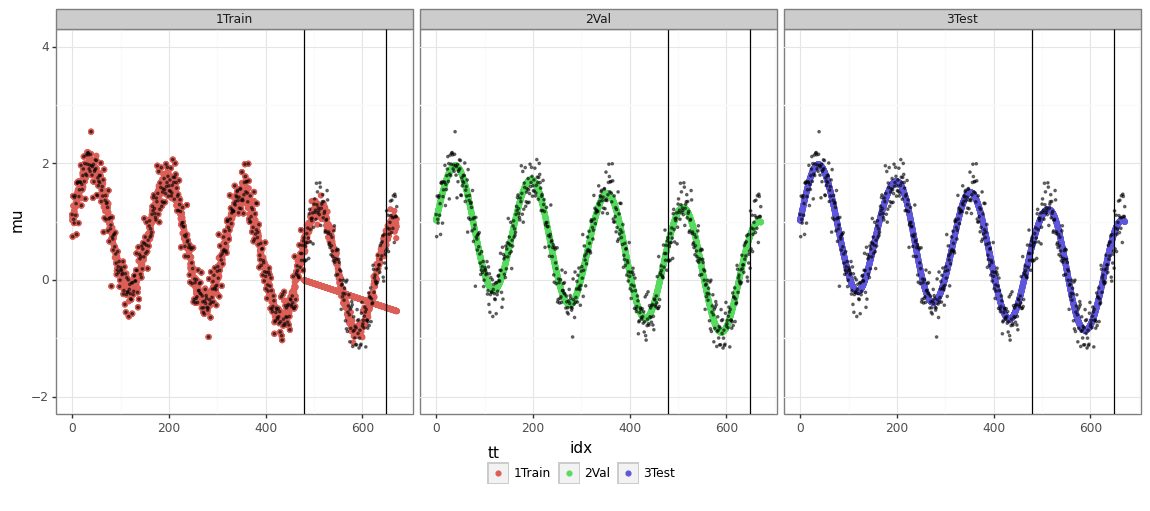

<ggplot: (8774099876673)>

In [115]:
plotnine.options.figure_size = (14, 5)
gg_sampled = (ggplot(best_ii, aes(x='idx',y='mu',color='tt')) + 
              geom_point() + theme_bw() + 
              facet_wrap('~tt') + theme(legend_position='bottom') + 
              geom_vline(xintercept=ntrain) + geom_vline(xintercept=n-ntest) + 
              scale_y_continuous(limits=[-2, 4]) + 
              geom_point(aes(x='idx',y='y'),color='black',data=df1.drop(columns=['tt']),size=0.5,alpha=0.5))
gg_sampled

ExpSineSquared(length_scale=2, periodicity=1) + WhiteKernel(noise_level=0.15) + DotProduct(sigma_0=1)
ExpSineSquared(length_scale=2.19, periodicity=1.13) + WhiteKernel(noise_level=0.0854) + DotProduct(sigma_0=0.00106)


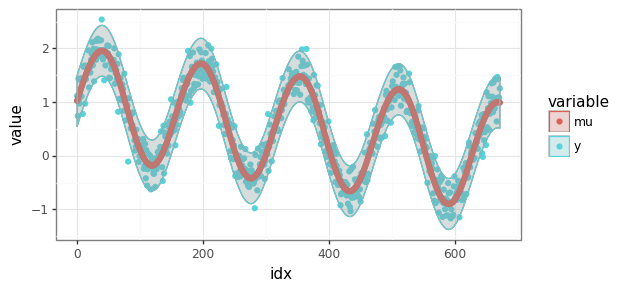

<ggplot: (8774096054837)>

In [116]:
kern = ExpSineSquared(length_scale=2, periodicity=1, length_scale_bounds=(0.1,3),periodicity_bounds=(0.1,2)) + \
        WhiteKernel(0.15) + DotProduct(1)
print(kern)
gpr = GaussianProcessRegressor(kernel=kern, normalize_y=True).fit(X1_train, y1_train)
print(gpr.kernel_)
mu, se = gpr.predict(np.r_[X1_train, X1_val, X1_test], True)
tmp = pd.DataFrame({'y':y1, 'mu':mu,'se':se,'idx':range(len(y1))}).assign(lb=lambda x: x.mu-crit*x.se, ub=lambda x: x.mu+crit*x.se)
tmp = tmp.melt(['idx','lb','ub','se'])
plotnine.options.figure_size = (6, 3)
(ggplot(tmp,aes(x='idx',y='value',color='variable')) + geom_point() + theme_bw() + 
 geom_ribbon(aes(ymin='lb',ymax='ub',fill='variable'),alpha=0.2))

In [ ]:
# "Tune" parameters to the training
kern1_star = store_kern[best_ii.ii[0]]
gpr1_star = GaussianProcessRegressor(kernel=kern1_star, normalize_y=True, optimizer=None).fit(X1_train, y1_train)
gpr1_tune = GaussianProcessRegressor(kernel=kern1_star, normalize_y=True, n_restarts_optimizer=5, random_state=seed)
gpr1_tune.fit(X1_train, y1_train)
print(gpr1_star.kernel_)
print(gpr1_tune.kernel_)
mu1_star, se1_star = gpr1_star.predict(np.r_[X1_train, X1_val, X1_test], True)
mu1_tune, se1_tune = gpr1_tune.predict(np.r_[X1_train, X1_val, X1_test], True)
res1 = pd.concat([pd.DataFrame({'mu':mu1_star,'se':se1_star,'mdl':'star'}),
                  pd.DataFrame({'mu':mu1_tune,'se':se1_tune,'mdl':'tune'})])
res1 = res1.assign(lb=lambda x: x.mu-crit*x.se, ub=lambda x: x.mu+crit*x.se).reset_index().rename(columns={'index':'idx'})

gg_res1 = (ggplot(res1, aes(x='idx',y='mu',color='mdl')) + theme_bw() + 
           geom_line() + geom_vline(xintercept=ntrain) + geom_vline(xintercept=n-ntest) + 
           geom_ribbon(aes(ymin='lb',ymax='ub',fill='mdl'),alpha=0.5) + 
           geom_point(aes(x='idx',y='y'),color='black',data=df1,size=0.5,alpha=0.5))
gg_res1

In [ ]:
# Make sure we can replicate how its making its predictions
xstar = X1_test[[20]]
K = gpr1_star.kernel_(gpr1_star.X_train_)
K = gpr1_star.L_.dot(gpr1_star.L_.T)
Kinv = np.linalg.inv(K + np.diag(np.repeat(gpr1_star.alpha,ntrain)))
kstar = np.atleast_2d(gpr1_star.kernel_(xstar, gpr1_star.X_train_))
print(kstar.dot(Kinv).dot(gpr1_star.y_train_ * gpr1_star._y_train_std + gpr1_star._y_train_mean))
# Note that Kinv * ytrain = alpha_
print(kstar.dot(gpr1_star.alpha_) * gpr1_star._y_train_std + gpr1_star._y_train_mean)
print(gpr1_star.predict(xstar))

## (2) GPyTorch

In [159]:
# gpytorch has five components to model building
# 1) GP model: gpytorch.models.exactGP, 2) gpytorch.likelihoods, 3) means, 4) Kernels, 5) Distribution

class gp(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(gp, self).__init__(train_x, train_y, likelihood)
        self.mean = ConstantMean()
        self.covar1 = ScaleKernel(RBFKernel())
        self.covar2 = LinearKernel()
        self.covar3 = ScaleKernel(CosineKernel())
        
    def forward(self, x):
        mean_x = self.mean(x)
        covar_x = self.covar2(x) + self.covar3(x) + self.covar1(x)
        out = MultivariateNormal(mean_x, covar_x)
        return out

Xtens1_train = torch.tensor(X1_train)
Xtens1_val = torch.tensor(X1_val)
Xtens1_trainval = torch.tensor(np.r_[X1_train, X1_val])
Xtens1_trainvaltest = torch.tensor(np.r_[X1_train, X1_val, X1_test])
ytens1_train = torch.tensor(y1_train)
ytens1_val = torch.tensor(y1_val)
ytens1_trainval = torch.cat([ytens1_train, ytens1_val])
ytens1_trainvaltest = torch.cat([ytens1_trainval, torch.tensor(y1_test)])

Xtens2_train = torch.tensor(X2_train)
Xtens2_val = torch.tensor(X2_val)
Xtens2_trainval = torch.tensor(np.r_[X2_train, X2_val])
Xtens2_trainvaltest = torch.tensor(np.r_[X2_train, X2_val, X2_test])
ytens2_train = torch.tensor(y2_train)
ytens2_val = torch.tensor(y2_val)
ytens2_trainval = torch.cat([ytens2_train, ytens2_val])
ytens2_trainvaltest = torch.cat([ytens2_trainval, torch.tensor(y2_test)])

Iter 25/100 - Loss: 0.740, lengthscale: 0.599, sig2: -0.199, noise: 0.579
Iter 50/100 - Loss: 0.648, lengthscale: 0.588, sig2: -0.224, noise: 0.472
Iter 75/100 - Loss: 0.556, lengthscale: 0.603, sig2: -0.190, noise: 0.382
Iter 100/100 - Loss: 0.466, lengthscale: 0.624, sig2: -0.143, noise: 0.307


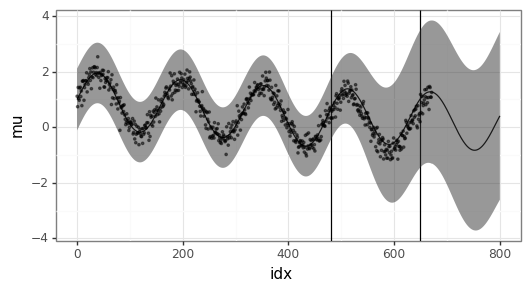

<ggplot: (8774122195129)>

In [160]:
ll = GaussianLikelihood()
mdl = gp(train_x=Xtens1_train, train_y=ytens1_train, likelihood=ll)
optimizer = torch.optim.Adam(params=mdl.parameters(), lr=0.01)
# marginal likelihood
mll = ExactMarginalLogLikelihood(ll, mdl)

import warnings
warnings.filterwarnings('ignore')

niter = 100
mdl.train(); ll.train()#  # Set model to training mode
mat_loss = np.zeros([niter, 2])
for i in range(niter):
    optimizer.zero_grad()  # Zero gradients from previous iteration
    output = mdl(Xtens1_train)  # Output from model
    loss = -mll(output, ytens1_train) # Calc loss and backprop gradients
    loss.backward()
    if (i + 1) % 25 == 0:
        print('Iter %d/%d - Loss: %.3f, lengthscale: %.3f, sig2: %.3f, noise: %.3f' % 
              (i + 1, niter, loss.item(), mdl.covar1.base_kernel.lengthscale.item(),
               mdl.covar1.base_kernel.raw_lengthscale.item(), mdl.likelihood.noise.item()))
    optimizer.step()
warnings.resetwarnings()

extra = cvec(np.arange(X1_test.max(),4,(X1_test.max() - X1_test.min())/X1_test.shape[0]))
mdl.eval()
ll.eval()
with torch.no_grad():
    tens = torch.tensor(np.r_[X1_train, X1_val, X1_test, extra])
    pred = ll(mdl(tens))

res_torch = pd.DataFrame({'mu':t2n(pred.mean),'se':t2n(pred.stddev)}).rename_axis('idx').reset_index()
res_torch = res_torch.assign(lb=lambda x: x.mu-crit*x.se, ub=lambda x: x.mu+crit*x.se)

gg_torch= (ggplot(res_torch, aes(x='idx',y='mu')) + 
           theme_bw() + geom_line() +  
           geom_vline(xintercept=ntrain) + geom_vline(xintercept=n-ntest) + 
           geom_ribbon(aes(ymin='lb',ymax='ub'),alpha=0.5) + 
           geom_point(aes(x='idx',y='y'),color='black',data=df1,size=0.5,alpha=0.5))
gg_torch

In [208]:
class gp2(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(gp2, self).__init__(train_x, train_y, likelihood)
        self.mean = ConstantMean()
        self.covar1 = CosineKernel() * RBFKernel()
        self.covar2 = CosineKernel() * LinearKernel()
        self.covar = self.covar1 + self.covar2
        
    def forward(self, x):
        mean_x = self.mean(x)
        covar_x = self.covar(x)
        out = MultivariateNormal(mean_x, covar_x)
        return out


Iter 50/100 - Loss: 0.121
Iter 100/100 - Loss: 0.088


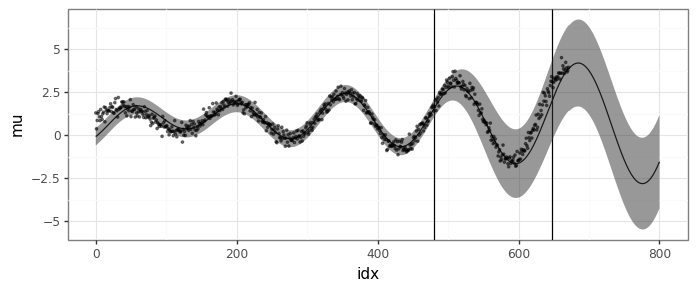

<ggplot: (8774039083857)>

In [259]:
ll = GaussianLikelihood()
mdl = gp2(train_x=Xtens2_train, train_y=ytens2_train, likelihood=ll)
optimizer = torch.optim.Adam(params=mdl.parameters(), lr=0.05)
# marginal likelihood
mll = ExactMarginalLogLikelihood(ll, mdl)

import warnings
warnings.filterwarnings('ignore')

niter = 100
mdl.train(); ll.train() # Set model to training mode
mat_loss = np.zeros([niter, 2])
for i in range(niter):
    optimizer.zero_grad()  # Zero gradients from previous iteration
    output = mdl(Xtens2_train)  # Output from model
    loss = -mll(output, ytens2_train) # Calc loss and backprop gradients
    loss.backward()
    if (i + 1) % 50 == 0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, niter, loss.item()))
        #print('\n'.join([f"{name}: {param.item():0.3f}" for name, param in mdl.named_parameters()]))
    optimizer.step()
warnings.resetwarnings()

mdl.eval()
ntweak = 1
for i in range(ntweak):
    optimizer.zero_grad()  # Zero gradients from previous iteration
    output = mdl(Xtens2_val)  # Output from model
    loss = -mll(output, ytens2_val) # Calc loss and backprop gradients
    loss.backward()
    optimizer.step()
    if (i + 1) % 5 == 0:
        print(loss.item())

extra = cvec(np.arange(X2_test.max(),4,(X2_test.max() - X2_test.min())/X2_test.shape[0]))
mdl.eval()
ll.eval()
with torch.no_grad():
    tens = torch.tensor(np.r_[X2_train, X2_val, X2_test, extra])
    pred = ll(mdl(tens))

res_torch = pd.DataFrame({'mu':t2n(pred.mean),'se':t2n(pred.stddev)}).rename_axis('idx').reset_index()
res_torch = res_torch.assign(lb=lambda x: x.mu-crit*x.se, ub=lambda x: x.mu+crit*x.se)

gg_torch= (ggplot(res_torch, aes(x='idx',y='mu')) + 
           theme_bw() + geom_line() +  
           geom_vline(xintercept=ntrain) + geom_vline(xintercept=n-ntest) + 
           geom_ribbon(aes(ymin='lb',ymax='ub'),alpha=0.5) + 
           geom_point(aes(x='idx',y='y'),color='black',data=df2,size=0.5,alpha=0.5))
gg_torch

## (2) Use actual data

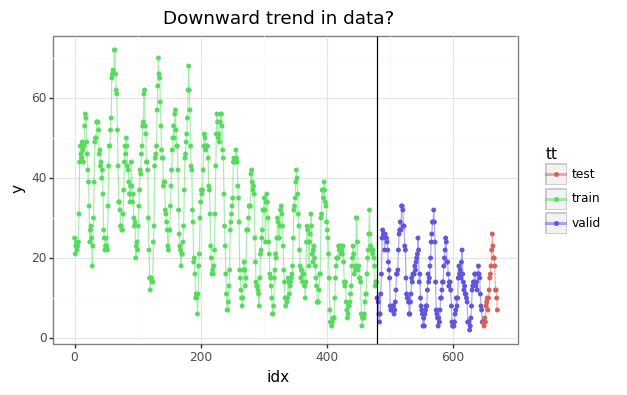

<ggplot: (8745277896093)>


In [87]:
cn = ['idx','hour']
dat = pd.read_csv(os.path.join(dir_flow,'test.csv')).rename(columns={'index':'idx'})
#dat['tt'] = np.where(dat.tt=='train','train','test')
idx_train, idx_valid, idx_test = dat[dat.tt=='train'].idx.values, dat[dat.tt=='valid'].idx.values, dat[dat.tt=='test'].idx.values

thresh1 = idx_train.max() + 1
thresh2 = idx_valid.max() + 1

y_train, y_valid, y_test = dat.y[idx_train].values, dat.y[idx_valid].values, dat.y[idx_test].values
X_train, X_valid, X_test = dat.loc[idx_train,cn].values, dat.loc[idx_valid,cn].values, dat.loc[idx_test,cn].values
nextra = 48
x_extra = np.c_[thresh2 + np.arange(nextra),np.tile(np.arange(24), int(nextra/24))]
enc = StandardScaler().fit(X_train)
X_train_til, X_valid_til, X_test_til, X_extra_til = enc.transform(X_train), enc.transform(X_valid), \
                                                    enc.transform(X_test), enc.transform(x_extra)
k = [0, 1]
X_train_tens, X_valid_tens, X_test_tens, X_extra_tens = torch.tensor(X_train_til[:,k]), torch.tensor(X_valid_til[:,k]), \
                                                        torch.tensor(X_test_til[:,k]), torch.tensor(X_extra_til[:,k])
y_train_tens, y_valid_tens, y_test_tens = torch.tensor(y_train.astype(float)), torch.tensor(y_valid.astype(float)), \
                                            torch.tensor(y_test.astype(float))
X_tval_tens, y_tval_tens = torch.cat([X_train_tens, X_valid_tens]), torch.cat([y_train_tens, y_valid_tens])

plotnine.options.figure_size = (6, 4)
gg_dat = (ggplot(dat, aes(x='idx', y='y',color='tt')) + 
          geom_point(size=1) + geom_line(size=0.5,alpha=0.5) + theme_bw() + 
          ggtitle('Downward trend in data?') + 
          geom_vline(xintercept=thresh1))
print(gg_dat)

df_hourly = dat.groupby('hour').y.describe().reset_index()
plotnine.options.figure_size = (4, 3)
gg_hourly = (ggplot(df_hourly, aes(x='hour', y='50%')) + 
             geom_point() + theme_bw() + 
             geom_linerange(aes(ymin='25%', ymax='75%')) + 
             ggtitle('Clear hourly trend'))
#print(gg_hourly)

torch.Size([649, 2])

In [129]:
class gp_real(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(gp_real, self).__init__(train_x, train_y, likelihood)
        self.mean = ConstantMean()
        self.linear1 = LinearKernel() # Single slope
        self.linear2 = ScaleKernel(LinearKernel()) # Temporal interaction with RBF
        self.rbf1 = RBFKernel() # Similarity on hour (X)
        self.rbf2 = ScaleKernel(RBFKernel()) # Temporal interaction with time
        self.cosine1 = ScaleKernel(CosineKernel()) # hour t-1, t+1 are similar
        
    def forward(self, x):
        mean_x = self.mean(x)
        covar_x1 = self.linear1(x[:,0]) + self.rbf1(x[:,1]) # Independent signals: time and hour
        covar_x2 = self.linear2(x[:,0]) * self.rbf2(x[:,1])
        covar_x3 = self.cosine1(x[:,0])
        covar_x = covar_x1 + covar_x2 + covar_x1*covar_x2 + covar_x3
        out = MultivariateNormal(mean_x, covar_x)
        return out

In [172]:
likelihood = GaussianLikelihood()
mdl = gp_real(train_x=X_tval_tens, train_y=y_tval_tens, likelihood=likelihood)
optimizer = torch.optim.Adam(params=mdl.parameters(), lr=0.1)
mll = ExactMarginalLogLikelihood(likelihood, mdl)

mdl.mean.constant = torch.nn.Parameter(y_tval_tens.mean())
mdl.likelihood.noise_covar.raw_noise = torch.nn.Parameter(torch.tensor([y_tval_tens.std()]))
print('\n'.join([f"{name}: {param.item():0.3f}" for name, param in mdl.named_parameters()]))

likelihood.noise_covar.raw_noise: 15.483
mean.constant: 25.826
linear1.raw_variance: 0.000
linear2.raw_outputscale: 0.000
linear2.base_kernel.raw_variance: 0.000
rbf1.raw_lengthscale: 0.000
rbf2.raw_outputscale: 0.000
rbf2.base_kernel.raw_lengthscale: 0.000
cosine1.raw_outputscale: 0.000
cosine1.base_kernel.raw_period_length: 0.000


In [181]:
#print('\n'.join([f"{name}: {param.item():0.3f}" for name, param in mdl.named_parameters()]))

In [178]:
# print(mdl.train_targets.shape)
# print(mdl.train_inputs[0].shape)
# xx = torch.cat([X_tval_tens, X_test_tens[0:1]])
# yy = torch.cat([y_tval_tens,y_test_tens[0:1]])
# mdl.set_train_data(inputs=xx, targets=yy, strict=False)

Iter 25/100 - Loss: 3.907
Iter 50/100 - Loss: 3.906
Iter 75/100 - Loss: 3.905
Iter 100/100 - Loss: 3.905


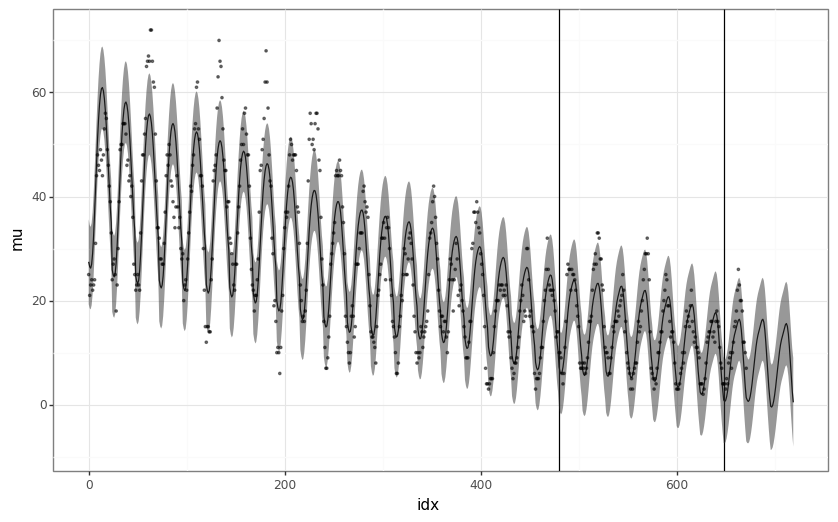

<ggplot: (8745261318269)>

In [179]:
niter = 100
mdl.train() # Set model to training mode
for i in range(niter):
    optimizer.zero_grad()
    output = mdl(xx)
    loss = -mll(output, yy) # Calc loss and backprop gradients
    loss.backward()
    if (i + 1) % 25 == 0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, niter, loss.item()))
        #print('\n'.join([f"{name}: {param.item():0.3f}" for name, param in mdl.named_parameters()]))
    optimizer.step()
    
mdl.eval(); likelihood.eval()
with torch.no_grad():
    tens = torch.cat([X_train_tens, X_valid_tens, X_test_tens, X_extra_tens],0)
    pred = likelihood(mdl(tens))

res_torch = pd.DataFrame({'mu':t2n(pred.mean),'se':t2n(pred.stddev)}).rename_axis('idx').reset_index()
res_torch = res_torch.assign(lb=lambda x: x.mu-crit*x.se, ub=lambda x: x.mu+crit*x.se)

plotnine.options.figure_size = (10, 6)
gg_torch= (ggplot(res_torch, aes(x='idx',y='mu')) + 
           theme_bw() + geom_line() +  
           geom_vline(xintercept=thresh1) + geom_vline(xintercept=thresh2) + 
           geom_ribbon(aes(ymin='lb',ymax='ub'),alpha=0.5) + 
           geom_point(aes(x='idx',y='y'),color='black',data=dat,size=0.5,alpha=0.5))
gg_torch

tt
train    0.799816
valid    0.770952
test     0.544259
dtype: float64


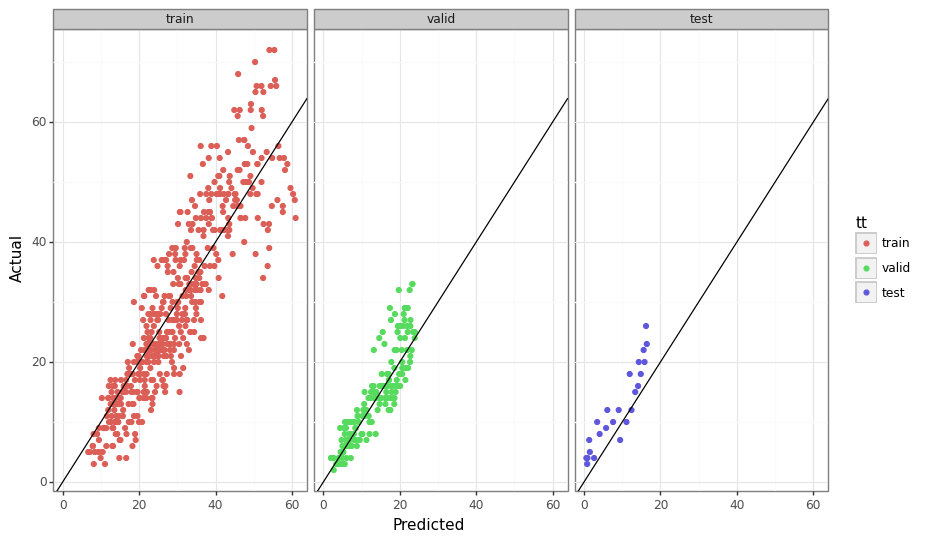

<ggplot: (8745354551345)>

In [180]:
tmp = dat.merge(res_torch,'left','idx').assign(tt=lambda x: pd.Categorical(x.tt,['train','valid','test']))
print(tmp.groupby('tt').apply(lambda x: r2_score(x.y, x.mu)))
(ggplot(tmp,aes(x='mu',y='y',color='tt'))+geom_point() + theme_bw() + facet_wrap('~tt') 
 + geom_abline(intercept=0,slope=1) + labs(x='Predicted',y='Actual'))

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression

def nadarya(x, X, y, ll=0.5):
    """
    FUNCTION TO IMPLEMENT NADARYA-WATSON LINEAR SMOOTHER
    """
    assert (x.shape[1] == X.shape[1]) & (X.shape[0] == y.shape[0])
    dist_l2 = pairwise_distances(X=x, Y=X, metric='l2')
    w_gauss = np.exp(-0.5 * dist_l2**2 / ll).T
    ytil = np.sum((w_gauss * cvec(y)), 0) / w_gauss.sum(0)
    return ytil
    
def local_reg(x, X, y, ll=0.5):
    assert (x.shape[1] == X.shape[1]) & (X.shape[0] == y.shape[0])
    dist_l2 = pairwise_distances(X=x, Y=X, metric='l2')
    w_gauss = np.exp(-0.5 * dist_l2**2 / ll).T.flatten()
    #endog = x - X
    mdl = LinearRegression(fit_intercept=True).fit(X, y, w_gauss)
    return mdl.predict(x)

In [ ]:
local_test = np.array([local_reg(x_test_til[[z]], x_train_til, y_train, ll=1) for z in range(x_test.shape[0])])
local_extra = np.array([local_reg(x_extra_til[[z]], x_train_til, y_train, ll=1) for z in range(x_extra.shape[0])])
qq = pd.DataFrame({'idx':np.append(x_test[:,0],x_extra[:,0]),'est':np.append(local_test, local_extra)})
gg_local = (ggplot(qq, aes(x='idx',y='est')) + theme_bw() +
            geom_point(size=0.5) + geom_line(size=0.5, alpha=0.5) + 
            geom_vline(xintercept=thresh2,color='blue'))
gg_local

In [ ]:
smooth1 = nadarya(np.vstack([x_train_til, x_test_til]), x_train_til, y_train, ll=0.5)
smooth2 = nadarya(np.vstack([x_train_til, x_test_til]), x_train_til, y_train, ll=2.5)
tmp = dat.assign(smooth1=smooth1, smooth2=smooth2).melt(['idx','y','tt'],
                    ['smooth1','smooth2'],'smooth').assign(res=lambda x: x.y - x.value)

plotnine.options.figure_size = (6, 4)
gg_dat = (ggplot(tmp, aes(x='idx', y='y')) + 
          geom_point(size=1) + geom_line(size=0.5,alpha=0.5) + theme_bw() + 
          ggtitle('Downward trend in data?') + 
          geom_line(aes(x='idx',y='value',color='smooth'),data=tmp) + 
          geom_vline(xintercept=thresh1))
gg_dat

In [ ]:
smooth3 = nadarya(np.vstack([x_test_til, x_extra_til]), x_train_til, y_train, ll=0.50)
tmp2 = pd.DataFrame({'idx':np.r_[x_test[:,0],x_extra[:,0]],'pred':smooth3})
plotnine.options.figure_size = (6, 4)
gg_cont = (ggplot(tmp2, aes(x='idx',y='pred')) + geom_point() + 
           theme_bw() + geom_line() + 
           geom_vline(xintercept=thresh2))
gg_cont